In [1]:
# Analyse de données - Seattle Building Energy Benchmarking
# ============================================================

# Installation des bibliothèques nécessaires
# pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("ANALYSE DE DONNÉES - SEATTLE BUILDING ENERGY BENCHMARKING")
print("="*80)

ANALYSE DE DONNÉES - SEATTLE BUILDING ENERGY BENCHMARKING


In [5]:
# 1. CHARGEMENT DES DONNÉES
# ============================================================
print("\n1. CHARGEMENT DES DONNÉES")
print("-"*80)

import os # Import os module to list directory contents

# The original kagglehub.load_dataset call failed because it could not find
# the file by the specified name within its internal dataset abstraction.
# However, the error message provided a hint that the files are locally mounted by Colab.

# Define the local path where the Kaggle dataset is mounted
dataset_local_path = "/kaggle/input/sea-building-energy-benchmarking"

print(f"  Listing files in the mounted Kaggle dataset directory: {dataset_local_path}")
try:
    available_files = os.listdir(dataset_local_path)
    for f in available_files:
        print(f"    - {f}")

    # Assuming the desired file is '2016_Building_Energy_Benchmarking.csv'
    # We construct the full path to load it directly using pandas.
    expected_filename = "2016_Building_Energy_Benchmarking.csv"

    if expected_filename in available_files:
        full_file_path = os.path.join(dataset_local_path, expected_filename)
        print(f"  Found '{expected_filename}'. Loading data from: {full_file_path}")
        df = pd.read_csv(full_file_path) # Use pandas directly
        print(f"✓ Dataset chargé avec succès depuis le chemin local!")
        print(f"  Dimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
    else:
        # Fallback if the expected filename isn't directly found, try to load any CSV
        print(f"  Warning: Expected file '{expected_filename}' not found. Searching for any .csv file...")
        csv_files = [f for f in available_files if f.endswith('.csv')]
        if csv_files:
            first_csv_file = csv_files[0]
            full_file_path = os.path.join(dataset_local_path, first_csv_file)
            print(f"  Loading the first found CSV file: '{first_csv_file}' from {full_file_path}")
            df = pd.read_csv(full_file_path)
            print(f"✓ Dataset chargé avec succès depuis le chemin local!")
            print(f"  Dimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
        else:
            raise FileNotFoundError(f"No CSV files found in the dataset directory: {dataset_local_path}")

except FileNotFoundError as e:
    print(f"  Error accessing dataset directory or file: {e}")
    print("  Please ensure the Kaggle dataset is correctly attached and mounted in Colab.")
    raise # Re-raise the exception after printing information
except Exception as e:
    print(f"  An unexpected error occurred during data loading: {e}")
    raise



1. CHARGEMENT DES DONNÉES
--------------------------------------------------------------------------------
  Listing files in the mounted Kaggle dataset directory: /kaggle/input/sea-building-energy-benchmarking
    - 2016-building-energy-benchmarking.csv
    - socrata_metadata_2016-building-energy-benchmarking.json
    - 2015-building-energy-benchmarking.csv
    - socrata_metadata_2015-building-energy-benchmarking.json
  Loading the first found CSV file: '2016-building-energy-benchmarking.csv' from /kaggle/input/sea-building-energy-benchmarking/2016-building-energy-benchmarking.csv
✓ Dataset chargé avec succès depuis le chemin local!
  Dimensions: 3376 lignes × 46 colonnes


In [6]:
# 2. EXPLORATION INITIALE
# ============================================================
print("\n2. EXPLORATION INITIALE")
print("-"*80)

print("\nPremières lignes:")
print(df.head())

print("\n\nInformations sur le dataset:")
print(df.info())

print("\n\nStatistiques descriptives:")
print(df.describe())



2. EXPLORATION INITIALE
--------------------------------------------------------------------------------

Premières lignes:
   OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNu

In [7]:
# 3. NETTOYAGE DES DONNÉES
# ============================================================
print("\n\n3. NETTOYAGE DES DONNÉES")
print("-"*80)

# Valeurs manquantes avant nettoyage
print("\nValeurs manquantes par colonne (avant nettoyage):")
missing_before = df.isnull().sum()
missing_pct = (missing_before / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Colonne': missing_before.index,
    'Valeurs manquantes': missing_before.values,
    'Pourcentage': missing_pct.values
})
print(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values('Valeurs manquantes', ascending=False))

# Sélection des colonnes numériques importantes pour l'analyse
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n✓ {len(numeric_cols)} colonnes numériques identifiées")

# Créer un dataframe de travail avec les colonnes clés
key_columns = [
    'PropertyGFABuilding',  # Surface du bâtiment
    'SiteEnergyUse(kBtu)',  # Consommation d'énergie
    'SiteEUIWN(kBtu/sf)',   # Intensité énergétique
    'TotalGHGEmissions',     # Émissions GES
    'Electricity(kBtu)',     # Électricité
    'NaturalGas(kBtu)',      # Gaz naturel
    'ENERGYSTARScore'        # Score ENERGY STAR
]

# Filtrer les colonnes qui existent dans le dataset
available_cols = [col for col in key_columns if col in df.columns]
print(f"\n✓ {len(available_cols)} colonnes clés disponibles: {available_cols}")

df_clean = df[available_cols].copy()

# Suppression des lignes avec trop de valeurs manquantes
threshold = len(available_cols) * 0.5  # Au moins 50% des colonnes doivent être remplies
df_clean = df_clean.dropna(thresh=threshold)

print(f"\n✓ Lignes supprimées (valeurs manquantes): {len(df) - len(df_clean)}")

# Suppression des valeurs aberrantes (outliers) en utilisant l'IQR
def remove_outliers(df, columns):
    df_out = df.copy()
    for col in columns:
        if col in df_out.columns and df_out[col].dtype in [np.float64, np.int64]:
            Q1 = df_out[col].quantile(0.25)
            Q3 = df_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            before = len(df_out)
            df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
            removed = before - len(df_out)
            if removed > 0:
                print(f"  • {col}: {removed} outliers supprimés")
    return df_out

print("\nSuppression des outliers:")
df_clean = remove_outliers(df_clean, available_cols)

# Imputation des valeurs manquantes restantes avec la médiane
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"  • {col}: imputé avec la médiane ({median_val:.2f})")

print(f"\n✓ Dataset nettoyé: {df_clean.shape[0]} lignes × {df_clean.shape[1]} colonnes")




3. NETTOYAGE DES DONNÉES
--------------------------------------------------------------------------------

Valeurs manquantes par colonne (avant nettoyage):
                            Colonne  Valeurs manquantes  Pourcentage
41                         Comments                3376       100.00
43                          Outlier                3344        99.05
27         YearsENERGYSTARCertified                3257        96.48
25      ThirdLargestPropertyUseType                2780        82.35
26   ThirdLargestPropertyUseTypeGFA                2780        82.35
23     SecondLargestPropertyUseType                1697        50.27
24  SecondLargestPropertyUseTypeGFA                1697        50.27
28                  ENERGYSTARScore                 843        24.97
22        LargestPropertyUseTypeGFA                  20         0.59
21           LargestPropertyUseType                  20         0.59
8                           ZipCode                  16         0.47
20        Lis



4. ANALYSE EXPLORATOIRE
--------------------------------------------------------------------------------

✓ Graphique sauvegardé: 01_distribution_variables.png


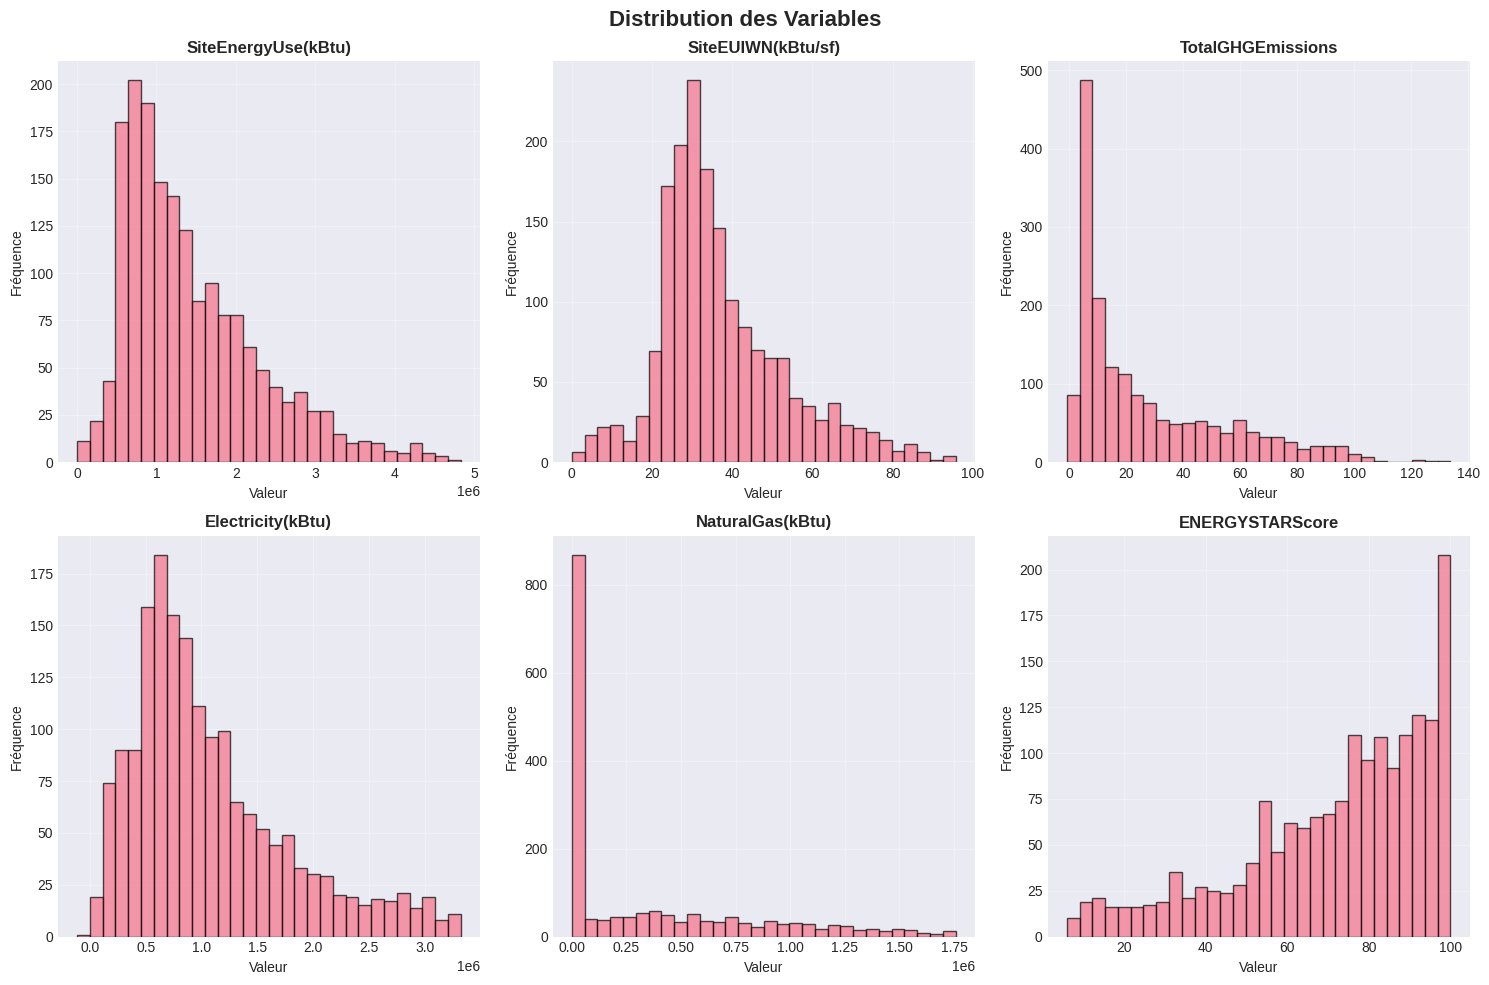

In [8]:
# 4. ANALYSE EXPLORATOIRE (EDA)
# ============================================================
print("\n\n4. ANALYSE EXPLORATOIRE")
print("-"*80)

# Distribution des variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution des Variables', fontsize=16, fontweight='bold')

for idx, col in enumerate(df_clean.columns[:6]):
    row = idx // 3
    col_idx = idx % 3
    axes[row, col_idx].hist(df_clean[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[row, col_idx].set_title(col, fontweight='bold')
    axes[row, col_idx].set_xlabel('Valeur')
    axes[row, col_idx].set_ylabel('Fréquence')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_distribution_variables.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphique sauvegardé: 01_distribution_variables.png")




5. MATRICE DE CORRÉLATION
--------------------------------------------------------------------------------

Matrice de corrélation:
                     SiteEnergyUse(kBtu)  SiteEUIWN(kBtu/sf)  \
SiteEnergyUse(kBtu)             1.000000            0.461313   
SiteEUIWN(kBtu/sf)              0.461313            1.000000   
TotalGHGEmissions               0.710421            0.567709   
Electricity(kBtu)               0.833481            0.195317   
NaturalGas(kBtu)                0.560955            0.534146   
ENERGYSTARScore                -0.150517           -0.392289   

                     TotalGHGEmissions  Electricity(kBtu)  NaturalGas(kBtu)  \
SiteEnergyUse(kBtu)           0.710421           0.833481          0.560955   
SiteEUIWN(kBtu/sf)            0.567709           0.195317          0.534146   
TotalGHGEmissions             1.000000           0.208641          0.946626   
Electricity(kBtu)             0.208641           1.000000          0.024673   
NaturalGas(kBtu)      

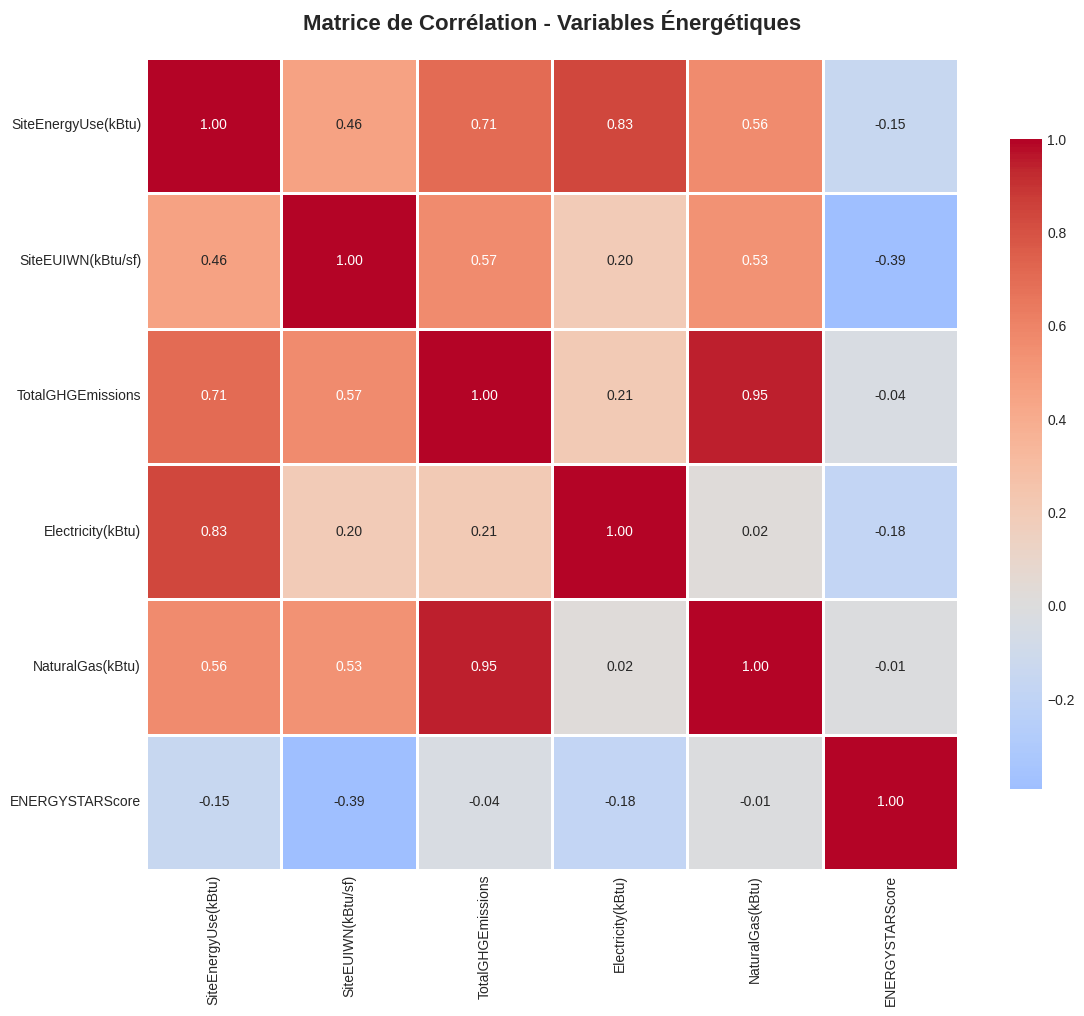

In [9]:
# 5. MATRICE DE CORRÉLATION
# ============================================================
print("\n\n5. MATRICE DE CORRÉLATION")
print("-"*80)

# Calculer la matrice de corrélation
correlation_matrix = df_clean.corr()

print("\nMatrice de corrélation:")
print(correlation_matrix)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation - Variables Énergétiques',
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('02_matrice_correlation.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphique sauvegardé: 02_matrice_correlation.png")

# Identifier les corrélations les plus fortes
print("\nTop 10 des corrélations les plus fortes:")
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Exclure les auto-corrélations
corr_pairs = corr_pairs.sort_values(ascending=False).drop_duplicates()
print(corr_pairs.head(10))



6. RÉGRESSION LINÉAIRE
--------------------------------------------------------------------------------

Variable cible: SiteEnergyUse(kBtu)
Variables explicatives: ['SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']

✓ Données divisées:
  • Entraînement: 1396 échantillons
  • Test: 349 échantillons

RÉSULTATS DE LA RÉGRESSION LINÉAIRE

Performance sur l'ensemble d'entraînement:
  • R² Score: 0.9973
  • RMSE: 45715.17

Performance sur l'ensemble de test:
  • R² Score: 1.0000
  • RMSE: 5421.65

Coefficients du modèle:
             Variable    Coefficient
2   Electricity(kBtu)  655013.313279
1   TotalGHGEmissions  337984.271287
3    NaturalGas(kBtu)  144455.695531
0  SiteEUIWN(kBtu/sf)    3499.926511
4     ENERGYSTARScore    2975.158062

✓ Graphique sauvegardé: 03_regression_lineaire.png


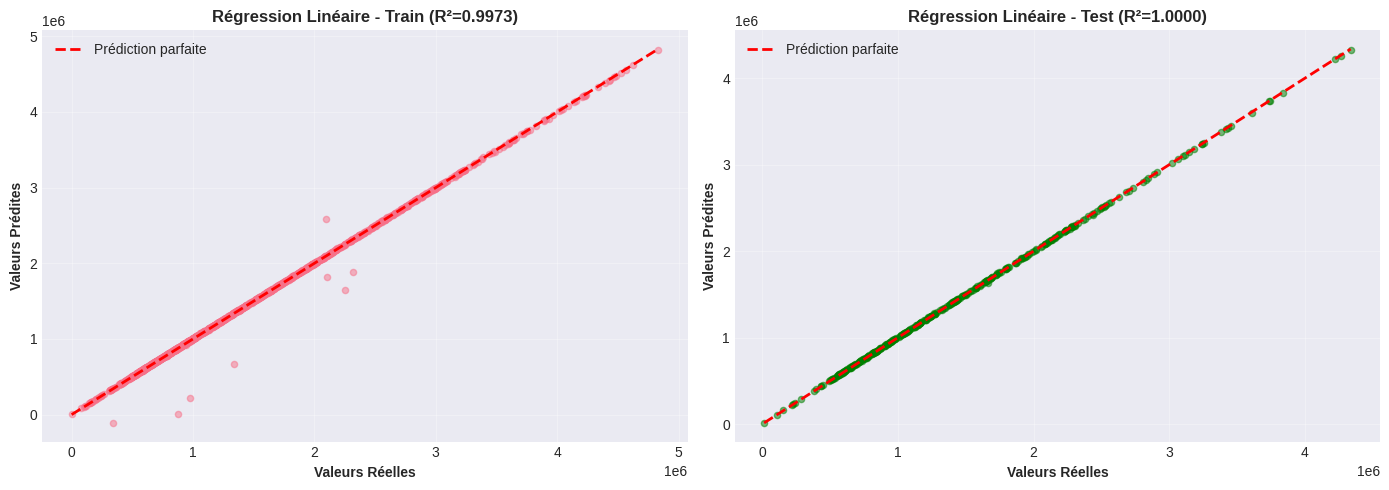

In [10]:
# 6. RÉGRESSION LINÉAIRE
# ============================================================
print("\n\n6. RÉGRESSION LINÉAIRE")
print("-"*80)

# Préparer les données pour la régression
# Variable cible: SiteEnergyUse (ou la première colonne numérique disponible)
target_col = 'SiteEnergyUse(kBtu)' if 'SiteEnergyUse(kBtu)' in df_clean.columns else df_clean.columns[0]
feature_cols = [col for col in df_clean.columns if col != target_col]

X = df_clean[feature_cols]
y = df_clean[target_col]

print(f"\nVariable cible: {target_col}")
print(f"Variables explicatives: {feature_cols}")

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n✓ Données divisées:")
print(f"  • Entraînement: {len(X_train)} échantillons")
print(f"  • Test: {len(X_test)} échantillons")

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du modèle
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Prédictions
y_pred_train = lr_model.predict(X_train_scaled)
y_pred_test = lr_model.predict(X_test_scaled)

# Évaluation
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\n" + "="*60)
print("RÉSULTATS DE LA RÉGRESSION LINÉAIRE")
print("="*60)
print(f"\nPerformance sur l'ensemble d'entraînement:")
print(f"  • R² Score: {train_r2:.4f}")
print(f"  • RMSE: {train_rmse:.2f}")
print(f"\nPerformance sur l'ensemble de test:")
print(f"  • R² Score: {test_r2:.4f}")
print(f"  • RMSE: {test_rmse:.2f}")

# Coefficients
print("\nCoefficients du modèle:")
coef_df = pd.DataFrame({
    'Variable': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False, key=abs)
print(coef_df)

# Visualisation des prédictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Valeurs réelles vs prédites (Train)
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()],
             [y_train.min(), y_train.max()],
             'r--', lw=2, label='Prédiction parfaite')
axes[0].set_xlabel('Valeurs Réelles', fontweight='bold')
axes[0].set_ylabel('Valeurs Prédites', fontweight='bold')
axes[0].set_title(f'Régression Linéaire - Train (R²={train_r2:.4f})', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Valeurs réelles vs prédites (Test)
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Prédiction parfaite')
axes[1].set_xlabel('Valeurs Réelles', fontweight='bold')
axes[1].set_ylabel('Valeurs Prédites', fontweight='bold')
axes[1].set_title(f'Régression Linéaire - Test (R²={test_r2:.4f})', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_regression_lineaire.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphique sauvegardé: 03_regression_lineaire.png")



7. RÉGRESSION LOGISTIQUE
--------------------------------------------------------------------------------

Variable cible créée: HighEfficiency
  • 0 = Efficacité faible (Score ≤ 78.00)
  • 1 = Efficacité élevée (Score > 78.00)

Distribution de la variable cible:
HighEfficiency
0    891
1    854
Name: count, dtype: int64

Proportions:
HighEfficiency
0    0.510602
1    0.489398
Name: proportion, dtype: float64

RÉSULTATS DE LA RÉGRESSION LOGISTIQUE

Précision sur l'ensemble d'entraînement: 0.9943
Précision sur l'ensemble de test: 0.9914

Rapport de classification (Test):
              precision    recall  f1-score   support

    Classe 0       1.00      0.98      0.99       178
    Classe 1       0.98      1.00      0.99       171

    accuracy                           0.99       349
   macro avg       0.99      0.99      0.99       349
weighted avg       0.99      0.99      0.99       349


✓ Graphique sauvegardé: 04_regression_logistique_confusion.png

Coefficients du modèle logist

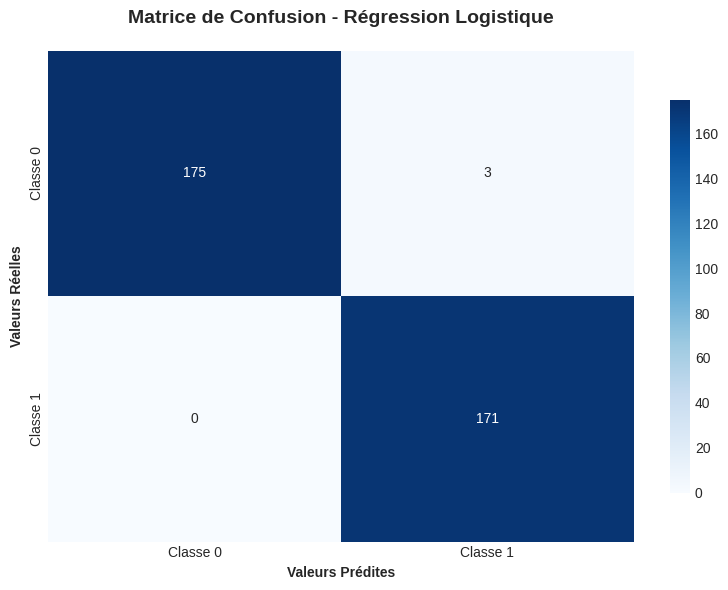

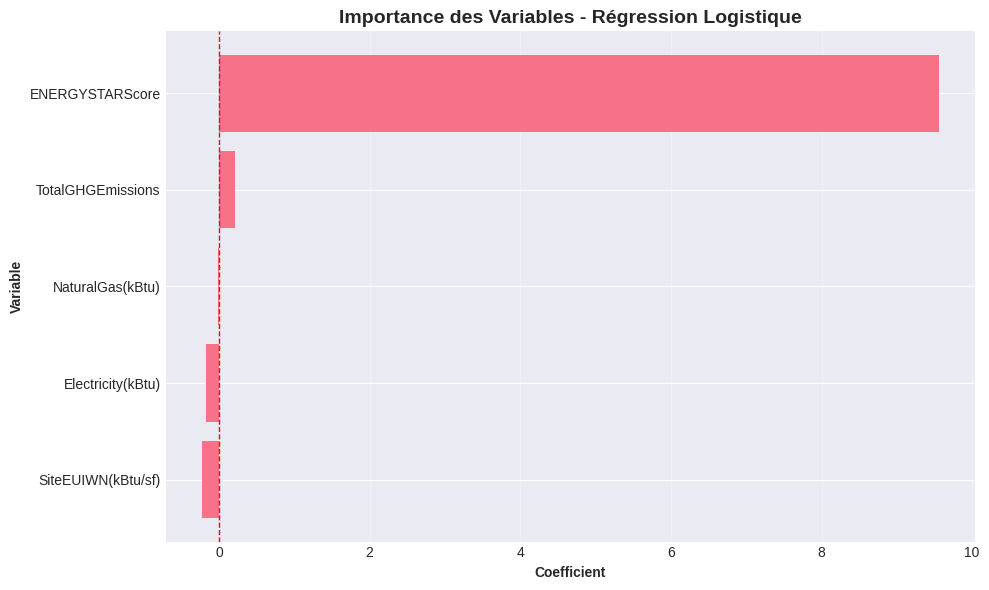

In [11]:
# 7. RÉGRESSION LOGISTIQUE
# ============================================================
print("\n\n7. RÉGRESSION LOGISTIQUE")
print("-"*80)

# Créer une variable binaire pour la classification
# Par exemple: bâtiments avec haute efficacité énergétique (ENERGY STAR > médiane)
if 'ENERGYSTARScore' in df_clean.columns:
    median_score = df_clean['ENERGYSTARScore'].median()
    df_clean['HighEfficiency'] = (df_clean['ENERGYSTARScore'] > median_score).astype(int)
    target_log = 'HighEfficiency'
    print(f"\nVariable cible créée: {target_log}")
    print(f"  • 0 = Efficacité faible (Score ≤ {median_score:.2f})")
    print(f"  • 1 = Efficacité élevée (Score > {median_score:.2f})")
else:
    # Alternative: utiliser la médiane de la consommation d'énergie
    median_energy = df_clean[target_col].median()
    df_clean['LowEnergy'] = (df_clean[target_col] <= median_energy).astype(int)
    target_log = 'LowEnergy'
    print(f"\nVariable cible créée: {target_log}")
    print(f"  • 0 = Consommation élevée (> {median_energy:.2f})")
    print(f"  • 1 = Consommation faible (≤ {median_energy:.2f})")

# Préparer les données
feature_cols_log = [col for col in df_clean.columns if col not in [target_log, target_col]]
X_log = df_clean[feature_cols_log]
y_log = df_clean[target_log]

print(f"\nDistribution de la variable cible:")
print(y_log.value_counts())
print(f"\nProportions:")
print(y_log.value_counts(normalize=True))

# Division train/test
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42, stratify=y_log
)

# Standardisation
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

# Entraînement du modèle
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_log_scaled, y_train_log)

# Prédictions
y_pred_train_log = log_model.predict(X_train_log_scaled)
y_pred_test_log = log_model.predict(X_test_log_scaled)

# Évaluation
train_accuracy = log_model.score(X_train_log_scaled, y_train_log)
test_accuracy = log_model.score(X_test_log_scaled, y_test_log)

print("\n" + "="*60)
print("RÉSULTATS DE LA RÉGRESSION LOGISTIQUE")
print("="*60)
print(f"\nPrécision sur l'ensemble d'entraînement: {train_accuracy:.4f}")
print(f"Précision sur l'ensemble de test: {test_accuracy:.4f}")

print("\nRapport de classification (Test):")
print(classification_report(y_test_log, y_pred_test_log,
                          target_names=['Classe 0', 'Classe 1']))

# Matrice de confusion
cm = confusion_matrix(y_test_log, y_pred_test_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'],
            cbar_kws={"shrink": 0.8})
plt.title('Matrice de Confusion - Régression Logistique',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Valeurs Réelles', fontweight='bold')
plt.xlabel('Valeurs Prédites', fontweight='bold')
plt.tight_layout()
plt.savefig('04_regression_logistique_confusion.png', dpi=300, bbox_inches='tight')
print("\n✓ Graphique sauvegardé: 04_regression_logistique_confusion.png")

# Coefficients du modèle logistique
print("\nCoefficients du modèle logistique:")
coef_log_df = pd.DataFrame({
    'Variable': feature_cols_log,
    'Coefficient': log_model.coef_[0]
}).sort_values('Coefficient', ascending=False, key=abs)
print(coef_log_df)

# Importance des variables (valeurs absolues des coefficients)
plt.figure(figsize=(10, 6))
coef_log_df_sorted = coef_log_df.sort_values('Coefficient')
plt.barh(coef_log_df_sorted['Variable'], coef_log_df_sorted['Coefficient'])
plt.xlabel('Coefficient', fontweight='bold')
plt.ylabel('Variable', fontweight='bold')
plt.title('Importance des Variables - Régression Logistique',
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('05_coefficients_logistique.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé: 05_coefficients_logistique.png")

In [12]:
# 8. RÉSUMÉ FINAL
# ============================================================
print("\n\n" + "="*80)
print("RÉSUMÉ DE L'ANALYSE")
print("="*80)
print(f"\n📊 Dataset original: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"📊 Dataset nettoyé: {df_clean.shape[0]} lignes × {df_clean.shape[1]} colonnes")
print(f"\n📈 Régression Linéaire:")
print(f"   • R² (Test): {test_r2:.4f}")
print(f"   • RMSE (Test): {test_rmse:.2f}")
print(f"\n📈 Régression Logistique:")
print(f"   • Précision (Test): {test_accuracy:.4f}")
print(f"\n✅ Graphiques générés:")
print(f"   • 01_distribution_variables.png")
print(f"   • 02_matrice_correlation.png")
print(f"   • 03_regression_lineaire.png")
print(f"   • 04_regression_logistique_confusion.png")
print(f"   • 05_coefficients_logistique.png")
print("\n" + "="*80)
print("ANALYSE TERMINÉE AVEC SUCCÈS!")
print("="*80)



RÉSUMÉ DE L'ANALYSE

📊 Dataset original: 3376 lignes × 46 colonnes
📊 Dataset nettoyé: 1745 lignes × 7 colonnes

📈 Régression Linéaire:
   • R² (Test): 1.0000
   • RMSE (Test): 5421.65

📈 Régression Logistique:
   • Précision (Test): 0.9914

✅ Graphiques générés:
   • 01_distribution_variables.png
   • 02_matrice_correlation.png
   • 03_regression_lineaire.png
   • 04_regression_logistique_confusion.png
   • 05_coefficients_logistique.png

ANALYSE TERMINÉE AVEC SUCCÈS!
